In [1]:
import numpy as np
train_file = '../pos-data/train_set.npy'
test_file = '../pos-data/test_set.npy'
vocab_file = '../pos-data/vocab.txt'
tagset_file = '../pos-data/tagset.txt'
import torch
import torch.autograd as autgrad
import torch.nn as nn
import torch.optim as optim


def argmax(vec):
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))


class CRF(nn.Module):
    def __init__(self, vocab_size, word2index, tag2index, embedding_dim):
        super(CRF, self).__init__()
        self.vocab_size = vocab_size
        self.tag2index = tag2index
        self.embedding_dim = embedding_dim
        self.target_size = len(tag2index)
        self.word2index = word2index
        self.hidden_dim = embedding_dim * 3 + 3

        self.transitions = nn.Parameter(torch.randn(self.target_size, self.target_size))
        self.transitions.data[tag2index[START_TAG], :] = -10000
        self.transitions.data[:, tag2index[STOP_TAG]] = -10000
        self.word_embeds = nn.Embedding(vocab_size + 2, embedding_dim)
        self.hidden2tag = nn.Linear(self.hidden_dim, self.target_size)

    def generate_function(self, sentence):
        T = len(sentence)
        functions = torch.zeros((T, 6))
        #         if_last, if first, ifCaptical, index_x, index_xt-1, index_xt+1
        for i, word in enumerate(sentence):
            if i == len(sentence) - 1:
                functions[i, 0] = 1
                functions[i, 5] = self.vocab_size
            else:
                functions[i, 0] = 0
                functions[i, 5] = sentence[i + 1]
            if i == 0:
                functions[i, 1] = 1
                functions[i, 4] = self.vocab_size + 1
            else:
                functions[i, 1] = 0
                functions[i, 4] = sentence[i - 1]
            raw_word = list(self.word2index.keys())[list(self.word2index.values()).index(word)]
            if any(c.isupper() for c in raw_word):
                functions[i, 2] = 1
            else:
                functions[i, 2] = 0
            functions[i, 3] = word
        return functions

    def get_features(self, sentence):
        functions = self.generate_function(sentence)  # T * 6
        embeds = torch.cat((functions[:, 0:3], self.word_embeds(functions[:, 3].long())), dim=1)
        embeds = torch.cat((embeds, self.word_embeds(functions[:, 4].long())), dim=1)
        embeds = torch.cat((embeds, self.word_embeds(functions[:, 5].long())), dim=1)
        features = self.hidden2tag(embeds)
        return features

    def forward_alg(self, feats):
        init_alphas = torch.full((1, self.target_size), -10000.)
        init_alphas[0][self.tag2index[START_TAG]] = 0
        forward_var = init_alphas
        for feat in feats:
            alphas_t = []
            for next_tag in range(self.target_size):
                emit_score = feat[next_tag].view(1, -1).expand(1, self.target_size)
                trans_score = self.transitions[next_tag].view(1, -1)
                next_tag_var = forward_var + trans_score + emit_score
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag2index[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def score_sentence(self, feats, tags):
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag2index[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag2index[STOP_TAG], tags[-1]]
        return score

    def viterbi_decode(self, feats):
        v_vars = torch.full((len(feats), self.target_size), 0.)
        v_labels = torch.full((len(feats), self.target_size), 0.)
        v_vars[0][:] = torch.full((1, self.target_size), -10000.)
        v_vars[0][self.tag2index[START_TAG]] = 0
        
        t = 0
        for i in range(self.target_size):
                next_v_var = v_vars[t][:] + self.transitions[i]
                next_v_var = next_v_var.view(1, self.target_size)
                max_prob = torch.max(next_v_var)
                max_prob_idx = argmax(next_v_var)
                v_vars[t][i] = max_prob + feats[t][i]
                v_labels[t][i] = max_prob_idx
        
        for t in range(1, len(feats)):
            for i in range(self.target_size):
                next_v_var = v_vars[t-1][:] + self.transitions[i]
                next_v_var = next_v_var.view(1, self.target_size)
                max_prob = torch.max(next_v_var)
                max_prob_idx = argmax(next_v_var)
                v_vars[t][i] = max_prob + feats[t][i]
                v_labels[t][i] = max_prob_idx
#             print(v_vars[t])
            
        opt = []
        eval_last = v_vars[-1][:] + self.transitions[self.tag2index[STOP_TAG]]
        last_max_pro = max(eval_last)
        previous = int(v_labels[-1][argmax(v_vars[-1][:].view(1, self.target_size))])
        opt.append(argmax(eval_last.view(1, self.target_size)))
        
        for t in range(len(feats) - 2, -1, -1):
            opt.insert(0, int(v_labels[t+1][previous]))
            previous = int(v_labels[t+1][previous])
        
        return last_max_pro, opt



    def neg_log_likelihood(self, sentence, tags):
        feats = self.get_features(sentence)
        forward_score = self.forward_alg(feats)
        gold_score = self.score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence): 
        feats = self.get_features(sentence)
        score, tag_seq = self.viterbi_decode(feats)
        return score, tag_seq


In [2]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"
EMBEDDING_DIM = 5

train_data = np.load(train_file)
test_data = np.load(test_file)
vocabs = {}
num = 0
with open(vocab_file, 'r') as f:
    for vocab in f.readlines():
        raw_vocab = vocab.strip()
        vocabs[raw_vocab] = num
        num += 1
tags = {}
num = 0
with open(tagset_file, 'r') as f:
    for tag in f.readlines():
        raw_tag = tag.strip()
        tags[raw_tag] = num
        num += 1

tags[START_TAG] = num
num += 1
tags[STOP_TAG] = num

model = CRF(len(vocabs), vocabs, tags, EMBEDDING_DIM)
optimizer = optim.RMSprop(model.parameters(), lr=0.01, weight_decay=1e-4)


for epoch in range(5):
    total_loss = []
    model.train()
    for sentence in train_data:
        model.zero_grad()
        sentence = np.array(sentence)
        words = sentence[:, 0]
        tag = sentence[:, 1]
        sentence_in = prepare_sequence(words, vocabs)
        targets = torch.tensor([tags[t] for t in tag], dtype=torch.long)
        loss = model.neg_log_likelihood(sentence_in, targets)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    print("In iteration %d, train loss: %f"%(epoch, np.mean(total_loss)))

    with torch.no_grad():
        model.eval()
        labels = []
        predicts = []
        for sentence in test_data:
            sentence = np.array(sentence)
            words = sentence[:, 0]
            tag = sentence[:,1]
            sentence_in = prepare_sequence(words, vocabs)
            targets = [tags[t] for t in tag]
            score, predict = model(sentence_in)
            labels.extend(targets)
            predicts.extend(predict)
        acc = sum(np.array(predicts)==np.array(labels)) / len(predicts)
        print("In iteration %d, the accuracy is %f" %(epoch, acc))

In iteration 0, train loss: 9.009008
In iteration 0, the accuracy is 0.942854
In iteration 1, train loss: 4.669903
In iteration 1, the accuracy is 0.946002
In iteration 2, train loss: 4.478593
In iteration 2, the accuracy is 0.946936
In iteration 3, train loss: 4.372778
In iteration 3, the accuracy is 0.948264
In iteration 4, train loss: 4.317327
In iteration 4, the accuracy is 0.948313


In [4]:
with torch.no_grad():
    model.eval()
    nll = []
    for sentence in train_data:
        sentence = np.array(sentence)
        words = sentence[:, 0]
        tag = sentence[:,1]
        sentence_in = prepare_sequence(words, vocabs)
        targets = torch.tensor([tags[t] for t in tag], dtype=torch.long)
        nll.append(model.neg_log_likelihood(sentence_in, targets))
    print(np.mean(nll))

3.1951396


In [5]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
cm = confusion_matrix(labels, predicts)

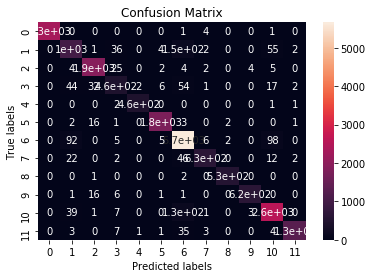

In [6]:
ax = plt.subplot()
import seaborn as sn
sn.heatmap(cm, annot=True, ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.yaxis.set_ticklabels(['health', 'business']);

In [33]:
model.word_embeds.weight.data

tensor([[-9.0652e-01, -1.8346e+00,  4.7555e-01,  1.3460e+00,  7.9870e-02],
        [ 1.7219e+00,  1.3708e+00, -2.2727e+00, -7.8400e-01, -8.4184e-01],
        [-1.4382e+00, -1.4497e+00,  2.7282e-01,  1.6747e+00, -7.2466e-01],
        ...,
        [ 1.0758e-40, -3.5955e-40, -6.5536e-40, -2.0971e-40,  2.7503e-40],
        [-3.5448e-01, -5.5258e-02,  6.6658e-01,  3.8250e-03, -2.5886e-01],
        [-5.8135e-01, -8.3625e-02,  1.2693e+00, -4.6400e-01, -1.0071e-01]])

In [36]:
model.hidden2tag.weight.data

tensor([[ 2.9449e-01, -1.6609e+00, -2.4256e+00, -8.9962e-01, -8.7165e+00,
          3.9329e+00,  6.5126e+00,  1.7742e+00,  2.8932e-01,  6.8417e-01,
         -1.8725e-01, -3.4366e-02,  2.3594e-01, -1.6863e-01,  3.9352e-01,
          1.1574e+00, -7.1709e-01,  7.7564e-01],
        [-1.1404e-01, -1.6084e+00, -2.7206e+00,  2.5778e+00,  3.5046e-01,
         -1.4977e+00,  3.3038e+00,  6.3636e+00,  7.5681e-02,  3.0350e-01,
         -4.2081e-01,  2.9496e-01,  3.5007e-01, -2.1373e-01,  5.9615e-01,
          1.4533e-01, -8.8530e-01,  6.5397e-01],
        [-1.3530e-01, -1.1465e+00, -2.3077e+00,  5.0848e-01, -3.0175e+00,
         -2.4841e+00, -1.8361e+00, -2.0204e+00,  8.4086e-02, -3.6800e-02,
          5.9464e-02,  9.6368e-02,  2.7637e-01,  2.7552e-01,  5.3805e-01,
          6.9255e-01, -1.3745e+00,  6.1141e-01],
        [-3.6180e-01, -1.8944e+00, -3.2949e+00, -1.5673e+00, -3.5832e+00,
         -5.9601e+00,  1.7661e+00,  1.3738e+00, -3.3403e-01,  3.0722e-01,
         -2.4032e-02,  3.5657e-01,  3.0